In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from dl_portfolio.data import load_data
from dl_portfolio.backtest import plot_perf, backtest_stats, get_target_vol_other_weights
import pickle
import os, sys
from sklearn.neighbors import KernelDensity
import seaborn as sns



# Some useful functions

In [ ]:

def plot_weights(weights, savepath=None, x_step=2):
    strat_to_plot = ['hrp', 'aerp', 'ae_rp_c',  'aeaa', 'hcaa', 'nmfrp',  'nmf_rp_c', 'nmfaa']
    nrow, ncol = 2,4
    fig, axs = plt.subplots(nrow, ncol, figsize=(18, 5), sharex=True, sharey=True)
    LABELS = [str(d.date()) for d in weights['hrp'].index]
    NUM_COLORS = len(weights[strat_to_plot[0]].columns)
    cm = plt.get_cmap('gist_rainbow')
    row = -1
    for i, strat in enumerate(strat_to_plot):
        print(strat)
        col = i % ncol
        if col == 0:
            row = row + 1
        print(row, col)
        axs[row, col].set_prop_cycle(color=[cm(1. * i / NUM_COLORS) for i in range(NUM_COLORS)])

        """if strat == 'equal_class':
            data = pd.DataFrame(np.repeat(weights['equal_class'].values, len(LABELS), axis=0),
                                columns = weights['hrp'].columns,
                                index = weights['hrp'].index)
        else:
            data = weights[strat]"""

        for j, c in enumerate(list(weights[strat].columns)):
            axs[row, col].bar(LABELS, weights[strat][c], label=c, width=1, align='edge',
                              bottom=weights[strat].iloc[:, :j].sum(1))    
        axs[row, col].tick_params(axis='x', labelrotation=45)
        _ = axs[row, col].set_xticks(list(range(0, len(weights[strat].index), x_step)))

    plt.subplots_adjust(hspace = .1)
    plt.subplots_adjust(wspace = .05)

    if save:
        plt.savefig(savepath, bbox_inches='tight', transparent=True)

def plot_final_backtest_performance(returns, benchmark, save=False, save_path=None, hedge=False):
    plt.figure(figsize=(20,10))
    plt.plot((returns['equal'] + 1).cumprod() - 1,
             label="equal",
             color="royalblue"
            )
    plt.plot((returns['equal_class'] + 1).cumprod() - 1,
             label="equal_class",
             color="navy"
            )
    plt.plot((returns['markowitz'] + 1).cumprod() - 1, label="markowitz", color="darkslategray")
    plt.plot((returns['GMV_robust'] + 1).cumprod() - 1, label="GMV_robust", color="teal")
    
    plt.plot((returns['hrp'] + 1).cumprod() - 1, label="hrp", color="red")
    plt.plot((returns['aerp'] + 1).cumprod() - 1, label="aerp", color="lightcoral")
    if hedge:
        plt.plot((returns['aerp_hedge'] + 1).cumprod() - 1, label="aerp-hedge", color="lightcoral")
    plt.plot((returns['nmfrp'] + 1).cumprod() - 1, label="nmfrp", color="indianred")
    
    plt.plot((returns['hcaa'] + 1).cumprod() - 1, label="hcaa", color="orangered")
    plt.plot((returns['kmaa'] + 1).cumprod() - 1, label="kmaa", color="firebrick")
    plt.plot((returns['aeaa'] + 1).cumprod() - 1, label="aeaa", color="orange")
    if hedge:
        plt.plot((returns['aeaa_hedge'] + 1).cumprod() - 1, label="aeaa-hedge", color="orange")
    plt.plot((returns['nmfaa'] + 1).cumprod() - 1, label="nmfaa", color="darkorange")
    
    plt.plot((returns['ae_rp_c'] + 1).cumprod() - 1, label="aerc-w", color="chartreuse")
    if hedge:
        plt.plot((returns['ae_rp_c_hedge'] + 1).cumprod() - 1, label="aerc-w-hedge", color="chartreuse")
    plt.plot((returns['nmf_rp_c'] + 1).cumprod() - 1, label="nmfrc-w", color="green")


    plt.plot((benchmark.loc[returns.index, 'SP500'] * 0.05 / (benchmark.loc[returns.index, 'SP500'].std() * np.sqrt(252)) + 1).cumprod() - 1, 
             label='SP500',
             color='purple')

    plt.plot((benchmark.loc[returns.index, 'Russel2000'] * 0.05 / (benchmark.loc[returns.index, 'Russel2000'].std() * np.sqrt(252)) + 1).cumprod() - 1,
             label='Russel2000',
             color='fuchsia')
    plt.plot((benchmark.loc[returns.index, 'EuroStoxx50'] * 0.05 / (benchmark.loc[returns.index, 'EuroStoxx50'].std() * np.sqrt(252)) + 1).cumprod() - 1, 
             label='EuroStoxx50',
             color='violet')
    
    plt.plot(np.cumprod(returns['ae_rp_c'] + 1) - np.cumprod(returns['ae_rp_c'] + 1), linestyle= '--', c="lightgrey")
    if save:
        plt.savefig(save_path, bbox_inches='tight', transparent=True)
    else:
        plt.legend()
        plt.show()
        
def load_all_backtest_result(ae_dir, nmf_dir, markowitz_dir, dataset):
    # Load Market budget
    if dataset == 'dataset1':
        market_budget = pd.read_csv('data/market_budget_dataset1.csv', index_col=0)
        cryptos = ['BTC', 'DASH', 'ETH', 'LTC', 'XRP']
        market_budget = pd.concat([market_budget, pd.DataFrame(np.array([['crypto', 1]] * len(cryptos)),
                                                               index=cryptos,
                                                               columns=market_budget.columns)])
        # market_budget = market_budget.drop('CRIX')
        market_budget['rc'] = market_budget['rc'].astype(int)
    elif dataset == 'dataset2':
        market_budget = pd.read_csv('data/market_budget_dataset2.csv', index_col=0)
        market_budget['rc'] = market_budget['rc'].astype(int)
    else:
        raise NotImplementedError()
        
    # Load markowitz and robust M results
    GMV_robust_weights = pd.read_csv(f"{markowitz_dir}/weights_GMV_robust.csv", index_col = 0)
    GMV_robust_weights.index = pd.to_datetime(GMV_robust_weights.index)
    markowitz_weights = pd.read_csv(f"{markowitz_dir}/weights_MeanVar_long.csv", index_col = 0)
    markowitz_weights.index = pd.to_datetime(markowitz_weights.index)
    
    # Leverage
    leverage = pd.read_csv(f'{ae_dir}/leverage.csv', index_col = 0)
    pyrobustm, l = get_target_vol_other_weights(f"GMV_robust_{dataset}")
    leverage["GMV_robust"] = l['other']
    pyrobustm.columns = ['GMV_robust']
    markowitz, l = get_target_vol_other_weights(f"MeanVar_{dataset}")
    leverage["markowitz"] = l['other']
    markowitz.columns = ['markowitz']
    
    port_weights = pickle.load(open(f'{ae_dir}/portfolios_weights.p', 'rb'))
    nmf_port_weights = pickle.load(open(f'{nmf_dir}/portfolios_weights.p', 'rb'))
    for k in nmf_port_weights.keys():
        key = k.replace("ae", "nmf")
        port_weights[key] = nmf_port_weights[k]
    port_weights["markowitz"] = markowitz_weights.loc[port_weights["ae_rp_c"].index]
    port_weights["GMV_robust"] = GMV_robust_weights.loc[port_weights["ae_rp_c"].index]


    ann_perf = pd.read_csv(f'{ae_dir}/portfolios_returns.csv', index_col = 0)
    ann_perf.index = pd.to_datetime(ann_perf.index)
    ann_perf['GMV_robust'] = pyrobustm['GMV_robust']
    ann_perf['markowitz'] = markowitz['markowitz']

    nmf_perf = pd.read_csv(f'{nmf_dir}/portfolios_returns.csv', index_col = 0)
    nmf_perf.index = pd.to_datetime(nmf_perf.index)
    nmf_perf.columns = [c.replace('ae', 'nmf') for c in nmf_perf.columns]
    common_cols = [c for c in nmf_perf.columns if "nmf" not in c]
    nmf_perf.drop(common_cols, 1, inplace = True)
    
    ann_perf = pd.concat([ann_perf, nmf_perf], 1)    
    stats = backtest_stats(ann_perf, port_weights, period=252, market_budget=market_budget)
    
    return ann_perf, port_weights, leverage, stats

# Save directory

In [3]:
SAVE=False
save=SAVE
savedir = "paper_result"
if save:
    if not os.path.isdir(savedir):
        os.mkdir(savedir)
   

# Load backtest result

In [4]:
 
benchmark, _ = load_data(dataset='dataset2')
benchmark = benchmark.pct_change().dropna()
benchmark = benchmark * 0.05 / (benchmark.std() * np.sqrt(252))
    
perf_ae_dir_1 = "./performance/test_final_models/ae/dataset1_20220322_150317"
perf_nmf_dir_1 = "./performance/test_final_models/nmf/dataset1_20220322_145318"
markowitz_dir1 = "final_models/run_7_global_bond_dl_portfolio_20220122_151211"
perf_ae_dir_2 = "./performance/test_final_models/ae/dataset2_20220323_152418"
perf_nmf_dir_2 = "./performance/test_final_models/nmf/dataset2_20220322_151938"
markowitz_dir2 = "final_models/run_6_multiasset_traditional_dl_portfolio_20211206_173539"
perf1, port_weights1, leverage1, stats1 = load_all_backtest_result(perf_ae_dir_1, 
                                                                   perf_nmf_dir_1,
                                                                   markowitz_dir1,
                                                                   "dataset1")
dates1 = perf1.index

perf2, port_weights2, leverage2, stats2 = load_all_backtest_result(perf_ae_dir_2, 
                                                                   perf_nmf_dir_2,
                                                                   markowitz_dir2,
                                                                   "dataset2")
dates2 = perf2.index

Formatting table
Formatting table


# Dataset 1

## Backtest performance

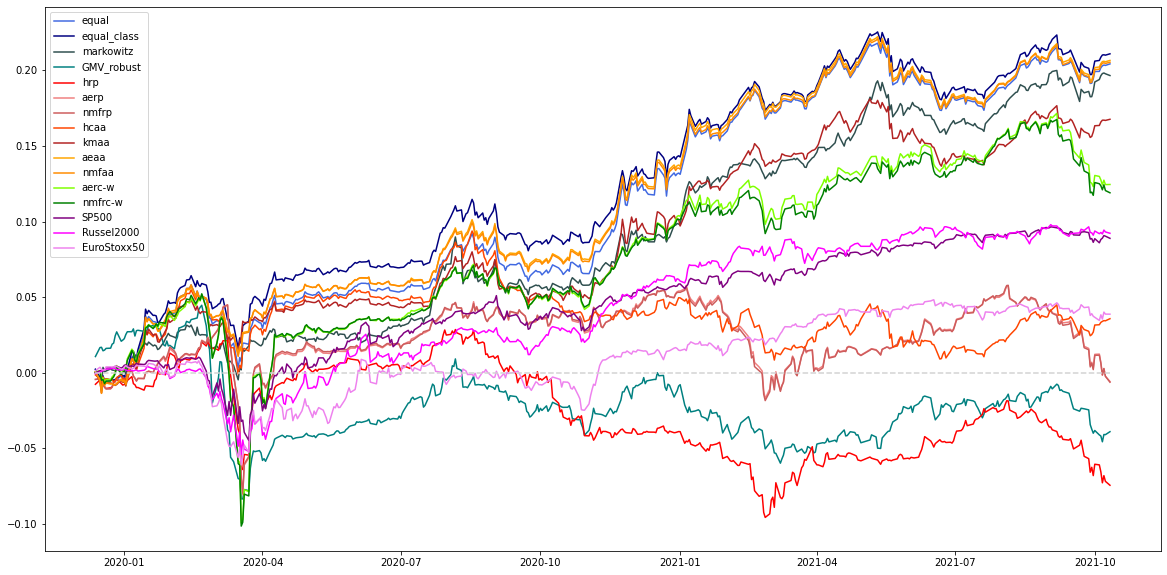

In [5]:
save = SAVE
save_path = f"{savedir}/performance_all_dataset1.png"
plot_final_backtest_performance(perf1, benchmark, save=save, save_path=save_path)


## Backtest stats

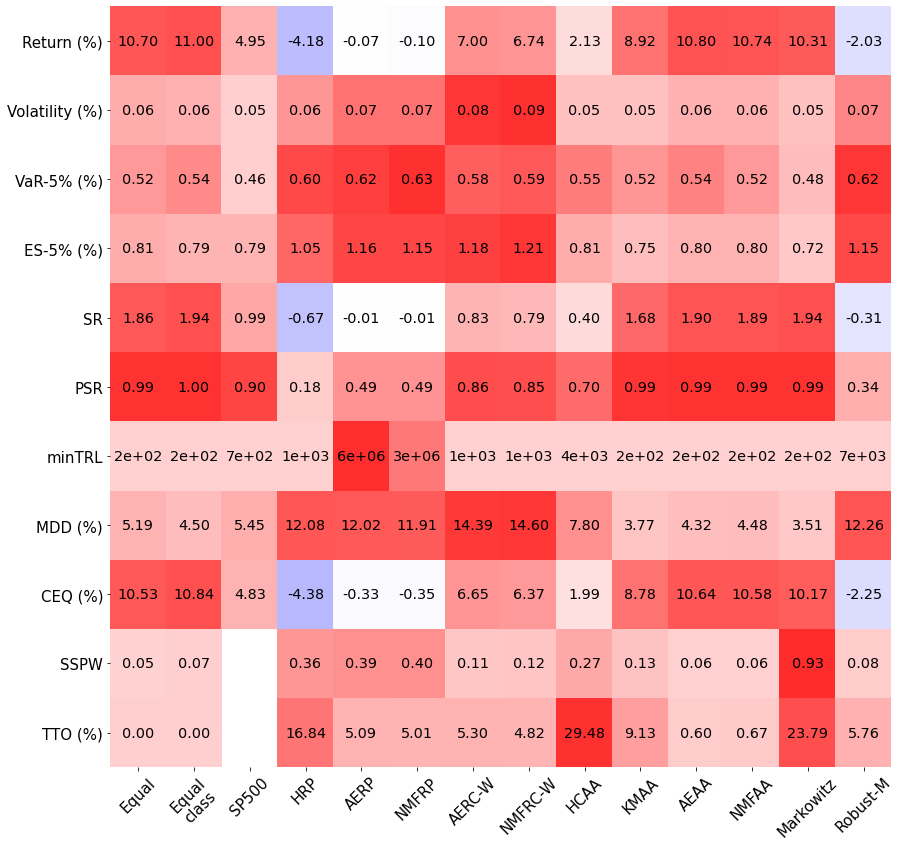

In [6]:
save = SAVE
ORDER = ["equal", "equal_class", "SP500", "hrp", "aerp", "nmfrp", "ae_rp_c", 
            "nmf_rp_c", "hcaa", "kmaa", "aeaa", "nmfaa", "markowitz", "GMV_robust"]

XTICKLABELS = ["Equal", "Equal\nclass", "SP500", "HRP", "AERP", "NMFRP", 
               "AERC-W", "NMFRC-W", "HCAA", "KMAA", "AEAA", "NMFAA",
               "Markowitz", "Robust-M"]
stats1.loc[['SP500', 'Russel2000', 'EuroStoxx50'], 'TTO'] = np.nan
pstats = stats1.drop(["Russel2000", "EuroStoxx50", "aeerc", "nmferc"])
pstats = pstats.loc[ORDER, :]


metrics = [c for c in list(pstats.columns) if c not in ['CR', 'Skewness', 'Excess kurtosis']]
fig, axs = plt.subplots(len(metrics), 1, figsize = (14,14), sharex = True)
i = 0
for i, c in enumerate(metrics):
    if c == "Return":
        cmap = "bwr"
    elif c == "Volatility":
        cmap="bwr"
        
    if c in ['Return', 'VaR-5%', 'ES-5%', 'Volatility', 'MDD', 'CEQ', 'TTO']:
        yticklabel = c + ' (%)'
    else:
        yticklabel = c
        
    temp = pstats.loc[:, [c]].T
    
    min_ = min(temp.loc[c])
    if min_ < 0:
        center = 0
    else:
        center=min(temp.loc[c]) - np.std(temp.loc[c])
    sns.heatmap(temp,
                cmap='bwr', 
                center=center, 
                vmin=min(temp.loc[c]) - np.std(temp.loc[c]),
                vmax=max(temp.loc[c]) + np.std(temp.loc[c]),
                annot=True,
                fmt='.2f' if c != "minTRL" else '.1g',
                annot_kws={'color': 'black', 'size': 'x-large', 'ha': 'center'},
                yticklabels = [yticklabel],
                xticklabels = XTICKLABELS,
                cbar=False,
                ax=axs[i])    
    axs[i].tick_params(axis='y', labelrotation = 0, labelsize=15)
    axs[i].tick_params(axis='x', labelrotation = 45,  labelsize=15)

plt.subplots_adjust(hspace = .000)

if save:
    plt.savefig(f'{savedir}/stats_heatmap_dataset1.png', bbox_inches='tight', transparent=True)

## Weights

hrp
0 0
aerp
0 1
ae_rp_c
0 2
aeaa
0 3
hcaa
1 0
nmfrp
1 1
nmf_rp_c
1 2
nmfaa
1 3


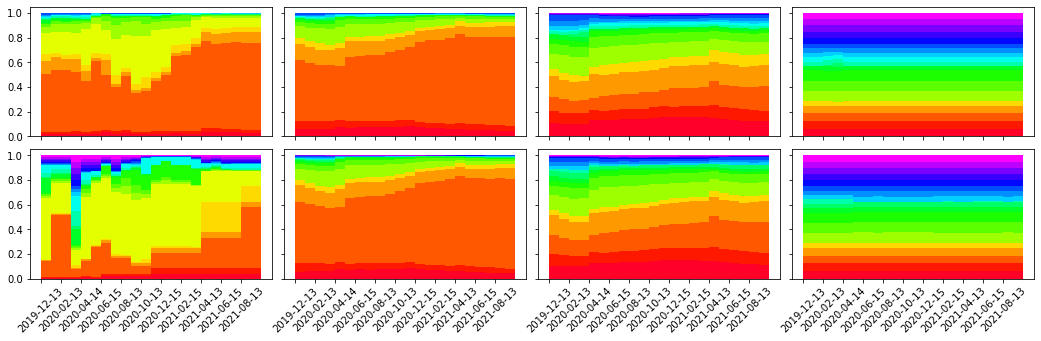

In [7]:
save=SAVE
weights = port_weights1.copy()        
if save:
    savepath = f'{savedir}/weights_barplot_dataset1.png'
else:
    savepath = None
plot_weights(weights, savepath=savepath)

# Dataset 2
## Backtest performance

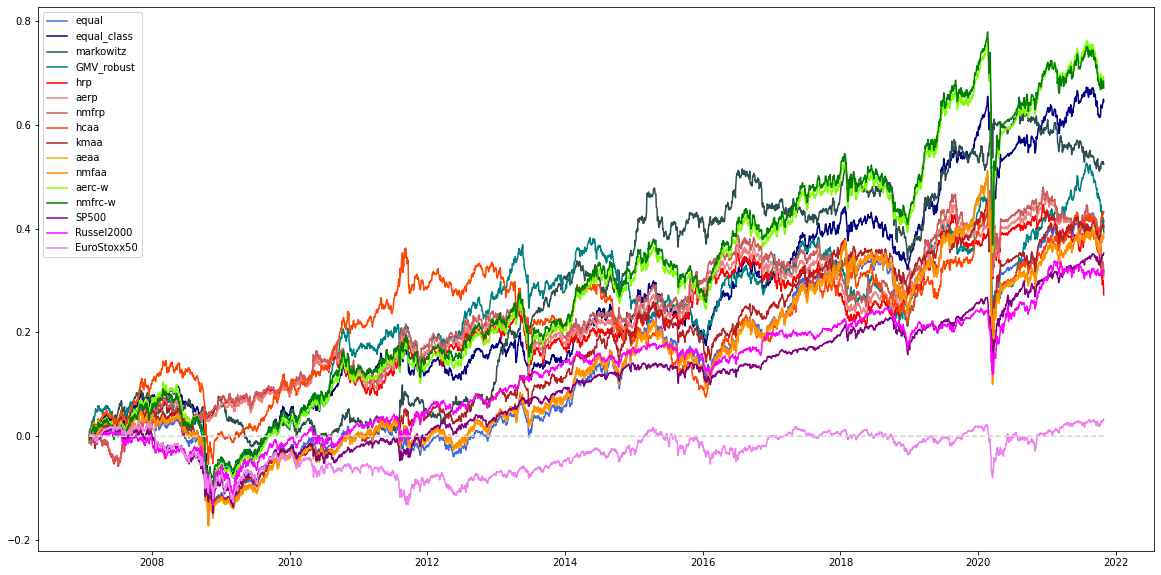

In [8]:
save = SAVE
save_path = f"{savedir}/performance_all_dataset2.png"
plot_final_backtest_performance(perf2, benchmark, save=save, save_path=save_path)


## Backtest stats

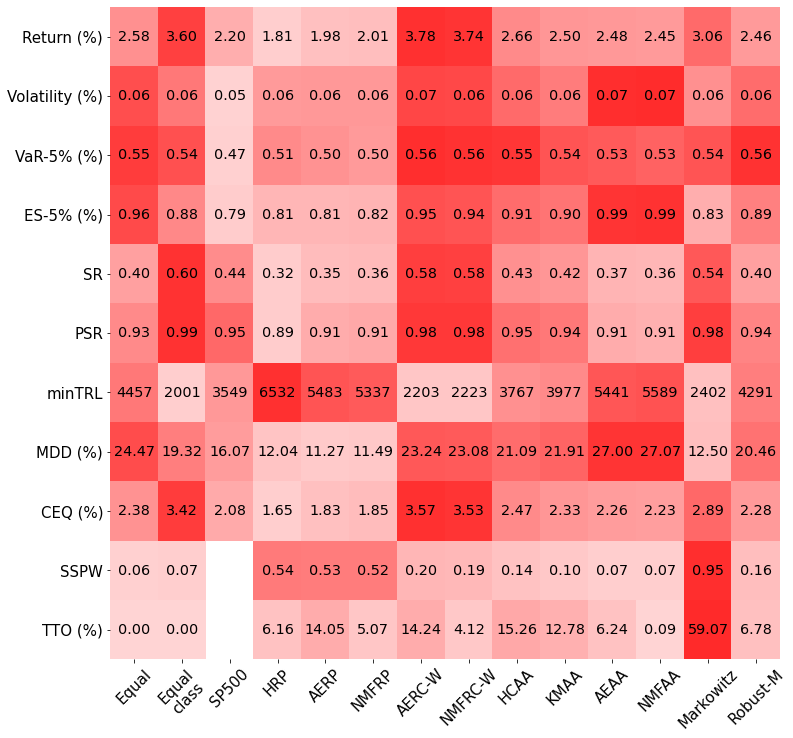

In [9]:
save = SAVE
stats2.loc[['SP500', 'Russel2000', 'EuroStoxx50'], 'TTO'] = np.nan
pstats = stats2.drop(["Russel2000", "EuroStoxx50", "aeerc", "nmferc"])
pstats = pstats.loc[ORDER, :]


metrics = [c for c in list(pstats.columns) if c not in ['CR', 'Skewness', 'Excess kurtosis']]
fig, axs = plt.subplots(len(metrics), 1, figsize = (12,12), sharex = True)
i = 0
for i, c in enumerate(metrics):
    if c == "Return":
        cmap = "bwr"
    elif c == "Volatility":
        cmap="bwr"
        
    if c in ['Return', 'VaR-5%', 'ES-5%', 'Volatility', 'MDD', 'CEQ', 'TTO']:
        yticklabel = c + ' (%)'
    else:
        yticklabel = c
        
    temp = pstats.loc[:, [c]].T
    min_ = min(temp.loc[c])
    if min_ < 0:
        center = 0
    else:
        center=min(temp.loc[c]) - np.std(temp.loc[c])
    sns.heatmap(temp,
                cmap='bwr', 
                center=center, 
                vmin=min(temp.loc[c]) - np.std(temp.loc[c]),
                vmax=max(temp.loc[c]) + np.std(temp.loc[c]),
                annot=True,
                fmt='.2f' if c != "minTRL" else '.0f',
                annot_kws={'color': 'black', 'size': 'x-large', 'ha': 'center'},
                yticklabels = [yticklabel],
                xticklabels = XTICKLABELS,
                cbar=False,
                ax=axs[i])    
    axs[i].tick_params(axis='y', labelrotation = 0, labelsize=15)
    axs[i].tick_params(axis='x', labelrotation = 45,  labelsize=15)

plt.subplots_adjust(hspace = .000)

if save:
    plt.savefig(f'{savedir}/stats_heatmap_dataset2.png', bbox_inches='tight', transparent=True)
   
    

## Weights

hrp
0 0
aerp
0 1
ae_rp_c
0 2
aeaa
0 3
hcaa
1 0
nmfrp
1 1
nmf_rp_c
1 2
nmfaa
1 3


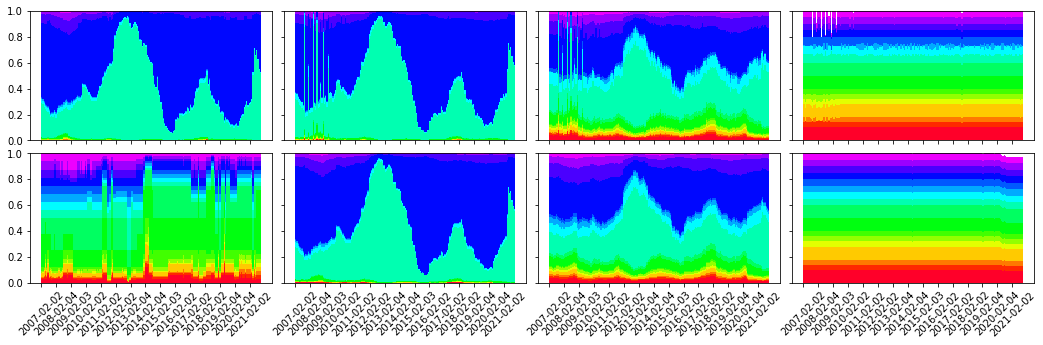

In [10]:
save=SAVE
weights = port_weights2.copy()        
if save:
    savepath = f'{savedir}/weights_barplot_dataset2.png'
else:
    savepath = None
plot_weights(weights, savepath=savepath, x_step=12)